In [ ]:
!pip install ultralytics -q
from ultralytics import YOLO
import os, yaml, random
from matplotlib import pyplot as plt
from PIL import Image
import cv2
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.8/978.8 kB 21.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.4 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 whic

In [3]:
# ⚙️ Configuración de paths
root = "/kaggle/input/plantvillage-for-object-detection-yolo/PlantVillage_for_object_detection/Dataset"

DATA_YAML = f"{root}/classes.yaml"
assert os.path.exists(DATA_YAML), "❌ No se encontró el archivo classes.yaml"
!cat {DATA_YAML}

names:
- Apple___Apple_scab
- Apple___Black_rot
- Apple___Cedar_apple_rust
- Apple___healthy
- Blueberry___healthy
- Cherry___Powdery_mildew
- Cherry___healthy
- Corn___Cercospora_leaf_spot Gray_leaf_spot
- Corn___Common_rust
- Corn___Northern_Leaf_Blight
- Corn___healthy
- Grape___Black_rot
- Grape___Esca_(Black_Measles)
- Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
- Grape___healthy
- Orange___Haunglongbing_(Citrus_greening)
- Peach___Bacterial_spot
- Peach___healthy
- Pepper,_bell___Bacterial_spot
- Pepper,_bell___healthy
- Potato___Early_blight
- Potato___Late_blight
- Potato___healthy
- Raspberry___healthy
- Soybean___healthy
- Squash___Powdery_mildew
- Strawberry___Leaf_scorch
- Strawberry___healthy
- Tomato___Bacterial_spot
- Tomato___Early_blight
- Tomato___Late_blight
- Tomato___Leaf_Mold
- Tomato___Septoria_leaf_spot
- Tomato___Spider_mites Two-spotted_spider_mite
- Tomato___Target_Spot
- Tomato___Tomato_Yellow_Leaf_Curl_Virus
- Tomato___Tomato_mosaic_virus
- Tomato___healthy


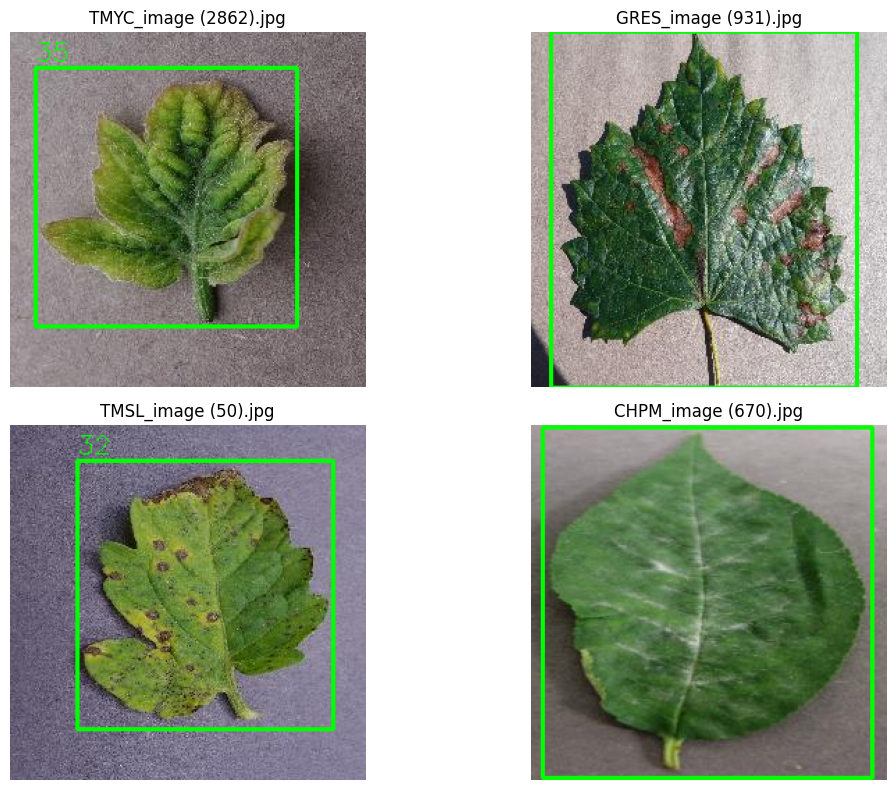

In [4]:
# 🔍 Visualización rápida de etiquetas y bounding boxes
image_dir = f"{root}/images"
label_dir = f"{root}/labels"
sample_images = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
random.shuffle(sample_images)
sample_images = sample_images[:4]

def draw_yolo_bbox(img_path, label_path):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    with open(label_path, 'r') as f:
        for line in f.readlines():
            cls, x, y, bw, bh = map(float, line.strip().split())
            x1, y1 = int((x - bw/2)*w), int((y - bh/2)*h)
            x2, y2 = int((x + bw/2)*w), int((y + bh/2)*h)
            cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
            cv2.putText(img, str(int(cls)), (x1,y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 1)
    return img

plt.figure(figsize=(12,8))
for i, fname in enumerate(sample_images):
    img_path = os.path.join(image_dir, fname)
    label_path = os.path.join(label_dir, fname.replace(".jpg", ".txt"))
    img = draw_yolo_bbox(img_path, label_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(fname)
    plt.axis('off')
plt.tight_layout()
plt.show()

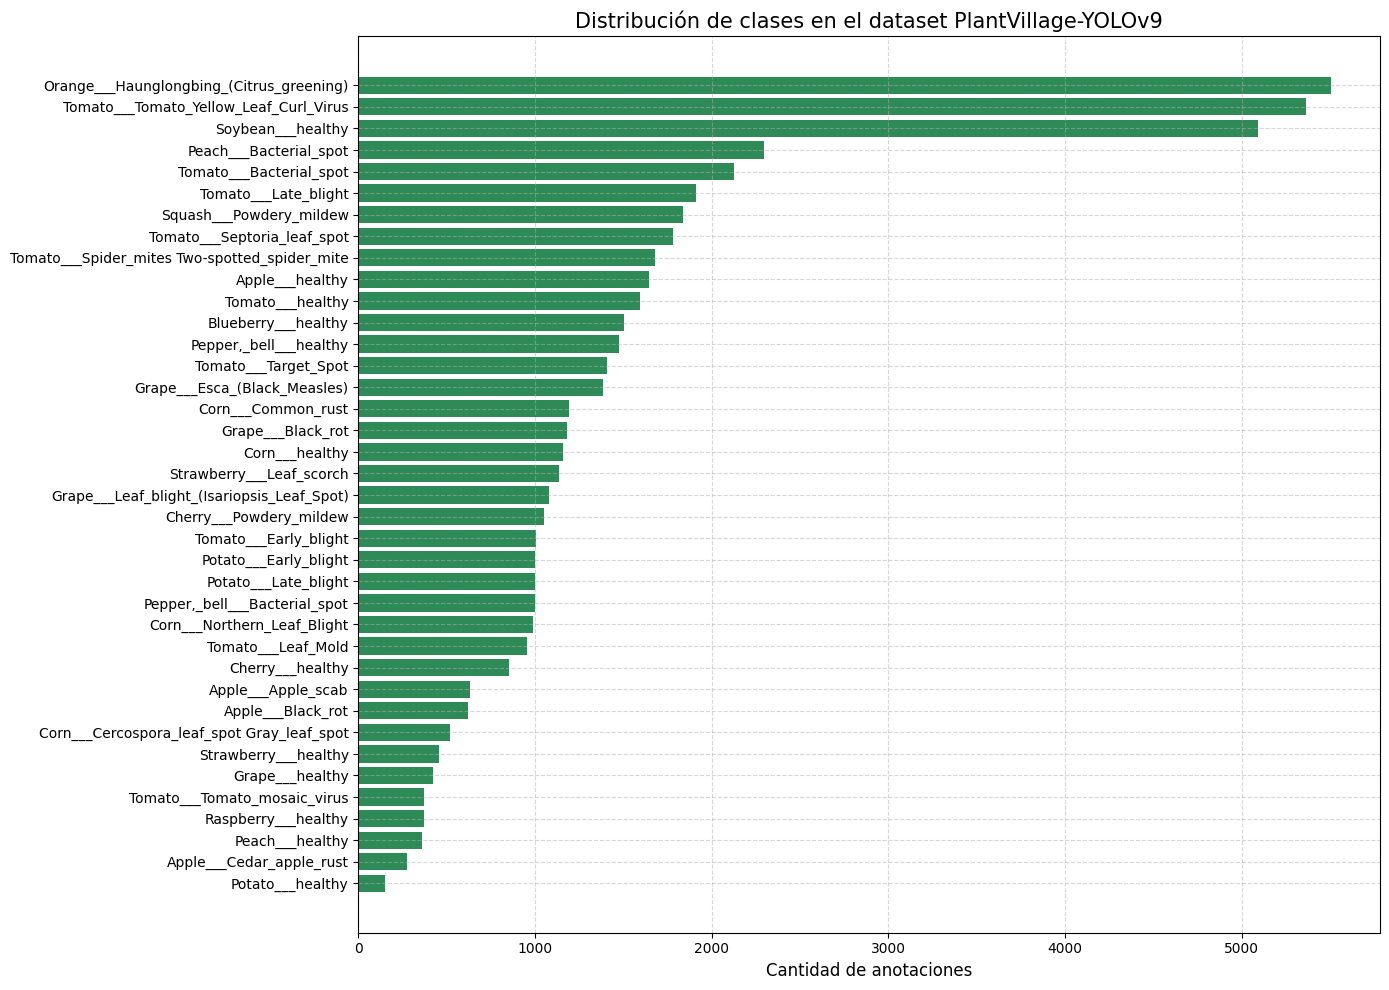

In [8]:
# 📊 Análisis general del dataset y distribución de clases
import yaml
from collections import Counter
import pandas as pd

# Leer nombres de clases desde classes.yaml
with open(DATA_YAML, 'r') as stream:
    data_yaml = yaml.safe_load(stream)
class_names = data_yaml['names']

# Contar instancias por clase asegurando formato correcto
label_counts = Counter()
for file in os.listdir(label_dir):
    if file.endswith(".txt"):
        with open(os.path.join(label_dir, file), "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:  # evitar errores por líneas vacías o mal formateadas
                    class_id = int(parts[0])
                    label_counts[class_id] += 1

# Crear DataFrame ordenado para visualización
df_counts = pd.DataFrame.from_dict(label_counts, orient='index', columns=['Count'])
df_counts['Class'] = df_counts.index.map(lambda x: class_names[x])
df_counts = df_counts.sort_values(by="Count", ascending=True)

# 📈 Visualización
plt.figure(figsize=(14, 10))
plt.barh(df_counts['Class'], df_counts['Count'], color="seagreen")
plt.xlabel("Cantidad de anotaciones", fontsize=12)
plt.title("Distribución de clases en el dataset PlantVillage-YOLOv9", fontsize=15)
plt.gca().tick_params(axis='y', labelsize=10)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [9]:
# ✅ Generar archivo data.yaml válido para YOLOv9

import yaml

# Ruta original del archivo con los nombres de clases
CLASSES_YAML = f"{root}/classes.yaml"

# Leer nombres de clases desde el YAML
with open(CLASSES_YAML, "r") as f:
    data_yaml = yaml.safe_load(f)
class_names = data_yaml["names"]

# Ruta destino del nuevo archivo data.yaml
data_yaml_path = "/kaggle/working/data.yaml"

# Generar el archivo con train, val, test, nombres y nc
with open(data_yaml_path, "w") as f:
    f.write(
        f"train: {root}/images\n"
        f"val: {root}/images\n"
        f"test: {root}/images\n"
        f"nc: {len(class_names)}\n"
        f"names: {class_names}\n"
    )

# Confirmar y asignar para entrenamiento
DATA_YAML = data_yaml_path
print("✅ Archivo data.yaml generado con éxito.")


✅ Archivo data.yaml generado con éxito.


In [ ]:
# 🚀 Entrenamiento con YOLOv9 (Ultralytics)
model = YOLO("yolov9c.pt")  # Modelo más balanceado: precisión y velocidad

model.train(
    data=DATA_YAML,
    epochs=150,
    imgsz=640,
    batch=16,
    name="plantvillage_yolo_train3",
    device=0
)

Ultralytics 8.3.109 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov9c.pt, data=/kaggle/working/data.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=plantvillage_yolo_train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=T

train: Scanning /kaggle/input/plantvillage-for-object-detection-yolo/PlantVillage_for_object_detection/Dataset/labels... 54293 images, 0 backgrounds, 0 corrupt: 100%|██████████| 54293/54293 [02:11<00:00, 412.77it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/plantvillage-for-object-detection-yolo/PlantVillage_for_object_detection/Dataset is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/plantvillage-for-object-detection-yolo/PlantVillage_for_object_detection/Dataset/labels... 54293 images, 0 backgrounds, 0 corrupt: 100%|██████████| 54293/54293 [00:50<00:00, 1067.88it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/plantvillage-for-object-detection-yolo/PlantVillage_for_object_detection/Dataset is not writeable, cache not saved.
Plotting labels to runs/detect/plantvillage_yolo_train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/plantvillage_yolo_train3
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      10.5G     0.4017      1.165      1.105         13        640: 100%|██████████| 3394/3394 [51:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1697/1697 [20:21<00:00,  1.39it/s]


                   all      54293      54348      0.956      0.924      0.976      0.957

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      10.5G     0.3932      0.613      1.071         15        640: 100%|██████████| 3394/3394 [50:30<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1697/1697 [20:16<00:00,  1.40it/s]


                   all      54293      54348      0.949      0.952      0.985       0.97

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      10.5G     0.4144     0.6303      1.079         13        640: 100%|██████████| 3394/3394 [50:14<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1697/1697 [20:12<00:00,  1.40it/s]


                   all      54293      54348      0.964      0.939      0.987      0.973

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      10.5G     0.3995     0.5855      1.071         15        640: 100%|██████████| 3394/3394 [50:05<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1697/1697 [20:11<00:00,  1.40it/s]


                   all      54293      54348      0.974      0.982      0.992      0.981

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      10.5G     0.3698     0.4967      1.054         15        640: 100%|██████████| 3394/3394 [50:07<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1697/1697 [20:09<00:00,  1.40it/s]


                   all      54293      54348      0.985      0.986      0.993      0.985

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      10.5G     0.3526     0.4433      1.044         15        640: 100%|██████████| 3394/3394 [50:07<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1697/1697 [20:11<00:00,  1.40it/s]


                   all      54293      54348      0.991       0.99      0.994      0.988

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      10.5G     0.3423     0.4132      1.039         14        640: 100%|██████████| 3394/3394 [50:07<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  77%|███████▋  | 1300/1697 [15:27<04:41,  1.41it/s]

In [ ]:
from ultralytics import YOLO

# ✅ Reanudar desde la época 8 con early stopping más rápido
model = YOLO("runs/detect/plantvillage_yolo_train3/weights/last.pt")

model.train(
    resume=True,
    epochs=25,     # entrenar hasta la época 25 como tope
    patience=5,    # parar si no mejora en 5 épocas
    name="plantvillage_yolo_train3_resumed"
)


Ultralytics 8.3.109 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=runs/detect/plantvillage_yolo_train3/weights/last.pt, data=/kaggle/working/data.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=plantvillage_yolo_train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=runs/detect/plantvillage_yolo_train3/weights/last.pt, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_tx

100%|██████████| 755k/755k [00:00<00:00, 7.74MB/s]
E0000 00:00:1744867951.552351      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744867951.617539      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorBoard: Start with 'tensorboard --logdir runs/detect/plantvillage_yolo_train3', view at http://localhost:6006/

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    212864  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 1]        
  3                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  4                  -1  1    847616  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 1]       
  5                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  6                  -1  1   2857472  ultralytics.nn.modules.block.RepNCSPELAN4    [5

train: Scanning /kaggle/input/plantvillage-for-object-detection-yolo/PlantVillage_for_object_detection/Dataset/labels... 54293 images, 0 backgrounds, 0 corrupt: 100%|██████████| 54293/54293 [04:45<00:00, 190.25it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/plantvillage-for-object-detection-yolo/PlantVillage_for_object_detection/Dataset is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/plantvillage-for-object-detection-yolo/PlantVillage_for_object_detection/Dataset/labels... 54293 images, 0 backgrounds, 0 corrupt: 100%|██████████| 54293/54293 [00:53<00:00, 1010.31it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/plantvillage-for-object-detection-yolo/PlantVillage_for_object_detection/Dataset is not writeable, cache not saved.
Plotting labels to runs/detect/plantvillage_yolo_train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
Resuming training runs/detect/plantvillage_yolo_train3/weights/last.pt from epoch 10 to 150 total epochs
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/plantvillage_yolo_train3
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      10.5G      0.322     0.3619       1.03         13        640: 100%|██████████| 3394/3394 [48:32<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1697/1697 [19:29<00:00,  1.45it/s]


                   all      54293      54348      0.993      0.995      0.994      0.992

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      10.4G     0.3196     0.3539      1.027         15        640: 100%|██████████| 3394/3394 [49:04<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1697/1697 [19:28<00:00,  1.45it/s]


                   all      54293      54348      0.994      0.995      0.994      0.992

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      10.4G     0.3165     0.3456      1.024         13        640: 100%|██████████| 3394/3394 [49:01<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1697/1697 [19:27<00:00,  1.45it/s]


                   all      54293      54348      0.995      0.995      0.994      0.992

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      10.4G     0.3134     0.3365      1.024         15        640: 100%|██████████| 3394/3394 [49:06<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1697/1697 [19:28<00:00,  1.45it/s]


                   all      54293      54348      0.995      0.996      0.994      0.992

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      10.4G     0.3111     0.3316      1.022         15        640: 100%|██████████| 3394/3394 [49:07<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1697/1697 [19:28<00:00,  1.45it/s]


                   all      54293      54348      0.996      0.995      0.995      0.992

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      10.4G     0.3089     0.3235      1.021         15        640: 100%|██████████| 3394/3394 [49:05<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1697/1697 [19:28<00:00,  1.45it/s]


                   all      54293      54348      0.996      0.995      0.995      0.993

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      10.4G     0.3076     0.3199       1.02         14        640: 100%|██████████| 3394/3394 [49:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1697/1697 [19:29<00:00,  1.45it/s]


                   all      54293      54348      0.996      0.996      0.995      0.993

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      10.4G     0.3048     0.3146      1.019         17        640: 100%|██████████| 3394/3394 [49:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1697/1697 [19:28<00:00,  1.45it/s]


                   all      54293      54348      0.996      0.996      0.995      0.993

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      10.4G     0.3036     0.3105      1.018         12        640: 100%|██████████| 3394/3394 [49:01<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1697/1697 [19:28<00:00,  1.45it/s]


                   all      54293      54348      0.997      0.996      0.995      0.993

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      10.4G     0.3049     0.3146      1.019         14        640: 100%|██████████| 3394/3394 [48:59<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1697/1697 [19:28<00:00,  1.45it/s]


                   all      54293      54348      0.997      0.996      0.995      0.993

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      10.4G     0.2999     0.3074      1.016         49        640:  30%|███       | 1032/3394 [14:54<34:17,  1.15it/s]

In [ ]:
from ultralytics import YOLO

model = YOLO("runs/detect/plantvillage_yolo_train3/weights/last.pt")

model.train(
    resume=True,
    epochs=25,      # máximo 25 más
    patience=2,     # early stopping rápido
)


Ultralytics 8.3.110 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=runs/detect/plantvillage_yolo_train3/weights/last.pt, data=/kaggle/working/data.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=plantvillage_yolo_train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=runs/detect/plantvillage_yolo_train3/weights/last.pt, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_tx

100%|██████████| 755k/755k [00:00<00:00, 16.9MB/s]
E0000 00:00:1744912200.813574      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744912200.950216      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorBoard: Start with 'tensorboard --logdir runs/detect/plantvillage_yolo_train3', view at http://localhost:6006/

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    212864  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 1]        
  3                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  4                  -1  1    847616  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 1]       
  5                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  6                  -1  1   2857472  ultralytics.nn.modules.block.RepNCSPELAN4    [5

train: Scanning /kaggle/input/plantvillage-for-object-detection-yolo/PlantVillage_for_object_detection/Dataset/labels... 54293 images, 0 backgrounds, 0 corrupt: 100%|██████████| 54293/54293 [06:23<00:00, 141.57it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/plantvillage-for-object-detection-yolo/PlantVillage_for_object_detection/Dataset is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 16.5±2.8 MB/s, size: 16.2 KB)


val: Scanning /kaggle/input/plantvillage-for-object-detection-yolo/PlantVillage_for_object_detection/Dataset/labels... 54293 images, 0 backgrounds, 0 corrupt: 100%|██████████| 54293/54293 [01:26<00:00, 624.64it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/plantvillage-for-object-detection-yolo/PlantVillage_for_object_detection/Dataset is not writeable, cache not saved.
Plotting labels to runs/detect/plantvillage_yolo_train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
Resuming training runs/detect/plantvillage_yolo_train3/weights/last.pt from epoch 20 to 150 total epochs
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/plantvillage_yolo_train3
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      10.5G     0.3017     0.2999      1.018         13        640: 100%|██████████| 3394/3394 [44:23<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1697/1697 [17:45<00:00,  1.59it/s]


                   all      54293      54348      0.997      0.996      0.995      0.993

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      10.4G     0.3018     0.3052      1.017         15        640: 100%|██████████| 3394/3394 [44:22<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1697/1697 [17:48<00:00,  1.59it/s]


                   all      54293      54348      0.997      0.996      0.995      0.993

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      10.4G     0.3009     0.3035      1.016         13        640: 100%|██████████| 3394/3394 [44:22<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1697/1697 [17:43<00:00,  1.60it/s]


                   all      54293      54348      0.997      0.996      0.995      0.993

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      10.4G      0.299     0.3008      1.016         15        640: 100%|██████████| 3394/3394 [44:24<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1697/1697 [17:43<00:00,  1.60it/s]


                   all      54293      54348      0.997      0.996      0.995      0.993

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      10.4G     0.2977      0.299      1.015         51        640:  27%|██▋       | 928/3394 [12:07<31:51,  1.29it/s]

In [4]:
import os

# Ruta del experimento anterior
weights_dir = "/kaggle/working/runs/detect/plantvillage_yolo_train3/weights"

# Verificar si existen
os.listdir(weights_dir) if os.path.exists(weights_dir) else "❌ Carpeta de pesos no encontrada"


['best.pt', 'last.pt']

In [9]:
import os

# Ruta del experimento
exp_dir = "runs/detect/plantvillage_yolo_train3"

# Listar archivos y carpetas dentro del experimento
for root, dirs, files in os.walk(exp_dir):
    print(f"\n📁 Carpeta: {root}")
    for name in files:
        print(f"  - 📄 {name}")



📁 Carpeta: runs/detect/plantvillage_yolo_train3
  - 📄 results.csv
  - 📄 events.out.tfevents.1744867962.0b40ef4e66f4.31.0
  - 📄 train_batch0.jpg
  - 📄 train_batch1.jpg
  - 📄 events.out.tfevents.1744912216.5b1f12f3a1d2.31.0
  - 📄 labels.jpg
  - 📄 labels_correlogram.jpg
  - 📄 events.out.tfevents.1744820528.0a1cc8244264.31.1
  - 📄 args.yaml
  - 📄 train_batch2.jpg

📁 Carpeta: runs/detect/plantvillage_yolo_train3/weights
  - 📄 best.pt
  - 📄 last.pt


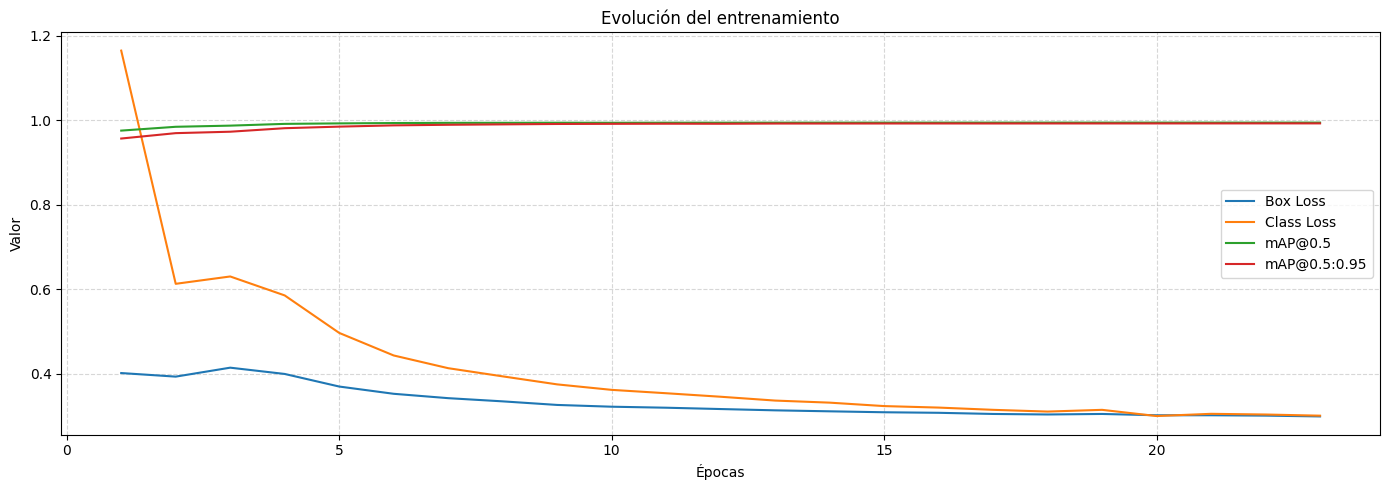

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Leer resultados
df = pd.read_csv("runs/detect/plantvillage_yolo_train3/results.csv")

# Graficar pérdidas y métricas (sin espacios en nombres de columnas)
plt.figure(figsize=(14, 5))
plt.plot(df['epoch'], df['train/box_loss'], label='Box Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Class Loss')
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
plt.xlabel("Épocas")
plt.ylabel("Valor")
plt.title("Evolución del entrenamiento")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
import os
import random
from ultralytics import YOLO

# Lista de imágenes reales del dataset
image_dir = "/kaggle/input/plantvillage-for-object-detection-yolo/PlantVillage_for_object_detection/Dataset/images"
all_images = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".jpg")]

# Elegir una muestra aleatoria de 20 imágenes
sample_images = random.sample(all_images, 20)

# Cargar el modelo y predecir sobre solo esas 20 imágenes
model = YOLO("runs/detect/plantvillage_yolo_train3/weights/best.pt")
results = model(sample_images, save=True, conf=0.4)



0: 640x640 1 Tomato___Bacterial_spot, 1395.8ms
1: 640x640 1 Soybean___healthy, 1395.8ms
2: 640x640 1 Orange___Haunglongbing_(Citrus_greening), 1395.8ms
3: 640x640 1 Soybean___healthy, 1395.8ms
4: 640x640 1 Blueberry___healthy, 1395.8ms
5: 640x640 1 Orange___Haunglongbing_(Citrus_greening), 1395.8ms
6: 640x640 1 Strawberry___healthy, 1395.8ms
7: 640x640 1 Squash___Powdery_mildew, 1395.8ms
8: 640x640 1 Orange___Haunglongbing_(Citrus_greening), 1395.8ms
9: 640x640 1 Tomato___Late_blight, 1395.8ms
10: 640x640 1 Strawberry___Leaf_scorch, 1395.8ms
11: 640x640 1 Potato___Late_blight, 1395.8ms
12: 640x640 1 Corn___Northern_Leaf_Blight, 1395.8ms
13: 640x640 1 Grape___Black_rot, 1395.8ms
14: 640x640 1 Apple___Cedar_apple_rust, 1395.8ms
15: 640x640 1 Grape___Esca_(Black_Measles), 1395.8ms
16: 640x640 1 Corn___healthy, 1395.8ms
17: 640x640 1 Potato___Early_blight, 1395.8ms
18: 640x640 1 Pepper,_bell___Bacterial_spot, 1395.8ms
19: 640x640 1 Grape___Black_rot, 1395.8ms
Speed: 3.1ms preprocess, 1395

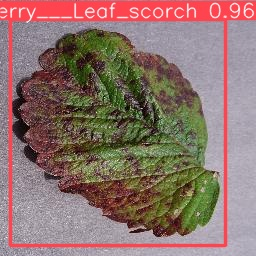

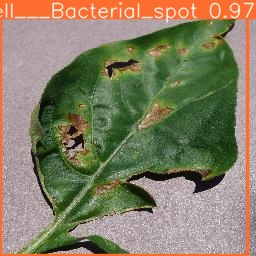

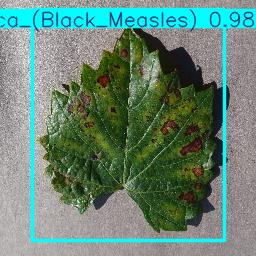

In [16]:
import os
import random
from IPython.display import Image, display

# Ruta donde YOLO guarda las inferencias
predict_dir = "runs/detect/predict2"

# Obtener todas las imágenes generadas con predicciones
predicted_images = [os.path.join(predict_dir, f) for f in os.listdir(predict_dir) if f.endswith(".jpg")]

# Mostrar aleatoriamente 3 imágenes con predicciones
random.seed(42)
samples = random.sample(predicted_images, min(3, len(predicted_images)))

for img_path in samples:
    display(Image(filename=img_path))


In [17]:
import shutil

# Exportar mejor modelo como PhytoGuard.pt
shutil.copy("runs/detect/plantvillage_yolo_train3/weights/best.pt", "PhytoGuard.pt")
print("✅ Modelo exportado como PhytoGuard.pt")


✅ Modelo exportado como PhytoGuard.pt
